# DiSignAtlas PreProcessing

## Get dsaids annotated as human genes

In [5]:
"""Get dsaids annotated as human genes

Structure:
    1. Imports, Variables, and Functions
    2. Load Data
    3. Get Human Genes
"""

# 1. Imports, Variables, and Functions
# imports
import pandas as pd, numpy as np, os, sys
from tqdm import tqdm
import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


# variables
output_path = os.path.join("..", "data", "DiSignAtlas", "dsa_diff_download.processed")
df_info_path = os.path.join(
    "..",
    "data",
    "DiSignAtlas",
    "Disease_information_Datasets.csv",
)


# functions
# get all entrez mouse ids
def get_mouse_entrez_ids():
    """Get Mouse Entrez IDs
    Returns:
        list: list of human entrez ids
    """
    data_path = os.path.join("..", "data", "ncbi_gene_info", "gene_info")
    df = pd.read_csv(data_path, sep="\t", usecols=["#tax_id", "GeneID"])
    df_mouse = df[df["#tax_id"] == 10090]
    logging.info(f"Nº of human genes: {len(df_mouse)}")
    return df_mouse["GeneID"].to_list()


# get all entrez human ids
def get_human_entrez_ids():
    """Get Human Entrez IDs
    Returns:
        list: list of human entrez ids
    """
    data_path = os.path.join("..", "data", "ncbi_gene_info", "gene_info")
    df = pd.read_csv(data_path, sep="\t", usecols=["#tax_id", "GeneID"])
    df_human = df[df["#tax_id"] == 9606]
    return df_human["GeneID"].to_list()

In [6]:
# 2. Load Data
df_data_info = pd.read_csv(df_info_path)

# 3. Get Human Genes
# get dsaids annotated as human genes
human_dsaids = df_data_info[df_data_info["organism"] == "Homo sapiens"][
    "dsaid"
].to_list()
# get Entrez human & mouse annotations
entrez_current_human_ids = get_human_entrez_ids()
entrez_current_mouse_ids = get_mouse_entrez_ids()

2024-02-07 20:06:23,621 - INFO - Nº of human genes: 112319


In [ ]:
## Get DeSignAtlas Genes for all dsaids

In [7]:
"""Get DeSignAtlas Genes for all dsaids
Structure:
    1. Imports, Variables, Functions
    2. Load Data
"""

# 1. Imports, Variables, Functions
# imports
from tqdm.contrib.concurrent import process_map


# variables
# path_diff_expr = os.path.join("..", "data", "DiSigAtlas", "dsa_diff_download")


# functions
def get_DiSignAtlas_gene_ids(dsaid):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )

    if os.path.exists(data_path):
        df = pd.read_csv(data_path, sep="\t")
        return dsaid, df["GeneID"].tolist()
    else:
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download",
            f"{dsaid}_whole_diff_regulation.csv",
        )

        df = pd.read_csv(data_path, sep=",")
        return dsaid, df["geneid"].tolist()


# 2. Load Data

total_genes = list()

result = process_map(
    get_DiSignAtlas_gene_ids, human_dsaids, max_workers=16, chunksize=10
)

100%|██████████| 7194/7194 [03:12<00:00, 37.33it/s]


In [8]:
d_dsaid_2_geneid = {i[0]: i[1] for i in result}

In [9]:
# quality check 0
check = True
for k, v in d_dsaid_2_geneid.items():
    if len(v) == 0:
        print(k)
        check = False
if check:
    logging.info("Quality Check: All dsaids have genes")

2024-02-07 20:09:36,609 - INFO - Quality Check: All dsaids have genes


## Filter 1: Drop dsaids with <50% of human genes

In [10]:
"""Filter 1: Drop dsaids with <50% of human genes

Structure:
    1. Imports, Variables, Functions
    2. Filter Data
"""

# 1. Imports, Variables, Functions
# imports


# variables
percentage = 0.50


# functions
def is_filter_1(genes, ref_genes=entrez_current_human_ids, percentage=percentage):
    """Is Filter 1
    Args:
        dsaid (str): dataset id of interest
        percentage: min % threshold of reference genes
        ref_genes: reference genes we expect to find
    """
    n_total_genes = len(genes)
    n_human_genes = len(set(genes) & set(ref_genes))
    if n_human_genes / n_total_genes >= percentage:
        return True
    else:
        return False


# 2. Filter Data
dsaids_pass_filter_1 = list()
dsaids_failed_filter_1 = list()
for dsaid in tqdm(human_dsaids):
    genes = d_dsaid_2_geneid.get(dsaid, list())
    if is_filter_1(genes):
        dsaids_pass_filter_1.append(dsaid)
    else:
        dsaids_failed_filter_1.append(dsaid)

100%|██████████| 7194/7194 [00:45<00:00, 157.01it/s]


In [32]:
logging.info(f"Nº of dsaids passing filter 1: {len(dsaids_pass_filter_1)}")
logging.info(f"Nº of dsaids failing filter 1: {len(dsaids_failed_filter_1)}")

2024-02-05 19:15:32,048 - INFO - Nº of dsaids passing filter 1: 7191
2024-02-05 19:15:32,049 - INFO - Nº of dsaids failing filter 1: 3


## Filter 2: Drop genes which are not in current ncbi genes nor are updated to ones

In [11]:
"""Drop genes which are not in current ncbi genes nor are updated to ones

Structure:
    1. Imports, Variables, Functions
    2. Get All genes which do not map to current ncbi
    3. Translate all genes we can to current ncbi
    4. Filter out rest
"""

# 1. Imports, Variables, Functions
# imports
from Bio import Entrez
from tqdm.contrib.concurrent import process_map


Entrez.email = "your_email@example.com"  # Always provide your email

# variables
output_path = os.path.join("..", "data", "DiSignAtlas", "dsa_diff_download.processed")


# functions
def fetch_gene_details(gene_id, retries=10):
    attempt = 0
    while attempt < retries:
        try:
            handle = Entrez.efetch(db="gene", id=gene_id, retmode="xml")
            records = Entrez.read(handle)
            handle.close()
            current_gene_names = []

            if records:
                for record in records:
                    # Check if the gene is from Homo sapiens
                    organism = record["Entrezgene_source"]["BioSource"][
                        "BioSource_org"
                    ]["Org-ref"]["Org-ref_taxname"]
                    if organism == "Homo sapiens":
                        gene_info = record["Entrezgene_gene"]
                        gene_ref = gene_info["Gene-ref"]
                        gene_name = (
                            gene_ref["Gene-ref_locus"]
                            if "Gene-ref_locus" in gene_ref
                            else "Name not found"
                        )

                        # Assuming current ID is correctly extracted here, but this needs verification
                        current_gene_name = (
                            record.get("Entrezgene_track-info", {})
                            .get("Gene-track", {})
                            .get("Gene-track_current-id", [{}])[0]
                            .get("Dbtag_tag", {})
                            .get("Object-id", {})
                            .get("Object-id_id", "Not found")
                        )

                        current_gene_names.append(current_gene_name)

                return gene_id, current_gene_names
            else:
                print(
                    f"No information found for Gene ID {gene_id}. Attempt {attempt + 1} of {retries}"
                )
                attempt += 1
                continue

        except Exception as e:
            print(f"An error occurred: {e}. Attempt {attempt + 1} of {retries}")
            attempt += 1
            continue

    return None  # Return None after exhausting retries


# 2. Get All genes which do not map to current ncbi
# all genes
all_genes = set()
for k, v in d_dsaid_2_geneid.items():
    all_genes.update(v)

not_current_ncbi_genes = all_genes - set(entrez_current_human_ids)

logging.info(f"Nº of unique genes annotated for Homo sapiend: {len(all_genes)}")
logging.info(f"Nº not in current ncbi: {len(not_current_ncbi_genes)}")

# 3. Translate all genes we can to current ncbi
no_updated_ncbi_gene = list()
updated_ncbi_gene = list()
for gene in tqdm(not_current_ncbi_genes):
    try:
        updated_ncbi_gene.append(fetch_gene_details(gene))
    except:
        no_updated_ncbi_gene.append(gene)
# 4. Filter out rest

2024-02-07 20:11:33,964 - INFO - Nº of unique genes annotated for Homo sapiend: 80877
2024-02-07 20:11:33,965 - INFO - Nº not in current ncbi: 31015
  0%|          | 85/31015 [01:05<6:09:16,  1.40it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or B

  0%|          | 86/31015 [01:12<22:48:58,  2.66s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  0%|          | 108/31015 [01:30<8:15:20,  1.04it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10


  1%|          | 175/31015 [02:25<6:43:21,  1.27it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  1%|          | 184/31015 [02:34<7:25:27,  1.15it/s] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  1%|          | 185/31015 [02:41<21:38:00,  2.53s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  1%|          | 209/31015 [02:58<5:52:45,  1.46it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  1%|          | 254/31015 [03:34<5:46:22,  1.48it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  1%|          | 283/31015 [03:58<5:48:18,  1.47it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  1%|          | 381/31015 [05:11<5:53:29,  1.44it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10


  2%|▏         | 501/31015 [06:39<7:08:16,  1.19it/s] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  2%|▏         | 502/31015 [06:46<22:05:05,  2.61s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or 

  2%|▏         | 503/31015 [06:53<34:01:39,  4.01s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  2%|▏         | 504/31015 [07:00<39:44:22,  4.69s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  2%|▏         | 567/31015 [07:51<5:38:22,  1.50it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  2%|▏         | 575/31015 [07:58<5:54:46,  1.43it/s]

An error occurred: IncompleteRead(14 bytes read). Attempt 1 of 10


  2%|▏         | 599/31015 [08:18<7:41:57,  1.10it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  2%|▏         | 630/31015 [08:42<5:43:29,  1.47it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  2%|▏         | 643/31015 [08:52<6:31:58,  1.29it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  2%|▏         | 644/31015 [08:55<10:31:49,  1.25s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  2%|▏         | 650/31015 [09:00<6:46:49,  1.24it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  2%|▏         | 669/31015 [09:15<5:33:37,  1.52it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  2%|▏         | 670/31015 [09:17<9:27:35,  1.12s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  2%|▏         | 736/31015 [10:22<9:07:24,  1.08s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  2%|▏         | 746/31015 [10:34<8:51:22,  1.05s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  3%|▎         | 788/31015 [11:15<7:08:13,  1.18it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  3%|▎         | 951/31015 [13:36<6:28:49,  1.29it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  3%|▎         | 975/31015 [13:57<8:10:00,  1.02it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  3%|▎         | 1005/31015 [14:21<6:01:10,  1.38it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  3%|▎         | 1040/31015 [14:51<5:33:09,  1.50it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  3%|▎         | 1059/31015 [15:06<6:02:02,  1.38it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  4%|▎         | 1105/31015 [15:44<8:24:05,  1.01s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  4%|▎         | 1137/31015 [16:11<8:03:12,  1.03it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  4%|▍         | 1198/31015 [17:00<5:21:57,  1.54it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  4%|▍         | 1292/31015 [18:14<6:03:14,  1.36it/s]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  4%|▍         | 1293/31015 [18:22<21:52:38,  2.65s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  4%|▍         | 1341/31015 [18:58<5:45:23,  1.43it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  4%|▍         | 1354/31015 [19:08<5:20:37,  1.54it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  5%|▍         | 1415/31015 [19:50<5:34:46,  1.47it/s]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1416/31015 [19:56<18:09:11,  2.21s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1420/31015 [19:59<9:21:11,  1.14s/it] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1421/31015 [20:06<22:50:32,  2.78s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1422/31015 [20:12<30:12:58,  3.68s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1423/31015 [20:13<23:15:53,  2.83s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1424/31015 [20:20<34:05:07,  4.15s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1427/31015 [20:23<17:30:23,  2.13s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1428/31015 [20:30<29:09:20,  3.55s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1442/31015 [20:42<6:23:11,  1.29it/s] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1443/31015 [20:48<19:37:24,  2.39s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1444/31015 [20:49<15:57:52,  1.94s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or B

  5%|▍         | 1445/31015 [20:56<28:19:14,  3.45s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1454/31015 [21:03<6:49:35,  1.20it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  5%|▍         | 1472/31015 [21:18<5:33:46,  1.48it/s] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 3 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 6 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that 

  5%|▍         | 1473/31015 [21:27<26:27:02,  3.22s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or 

  5%|▍         | 1474/31015 [21:34<35:49:31,  4.37s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1475/31015 [21:34<26:52:41,  3.28s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1476/31015 [21:40<33:12:26,  4.05s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1477/31015 [21:46<38:22:12,  4.68s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1488/31015 [21:54<6:33:59,  1.25it/s] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1489/31015 [22:01<21:12:28,  2.59s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1490/31015 [22:08<31:33:23,  3.85s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1502/31015 [22:16<6:16:15,  1.31it/s] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1503/31015 [22:22<19:49:11,  2.42s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1504/31015 [22:29<29:18:41,  3.58s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1505/31015 [22:29<22:15:15,  2.71s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1506/31015 [22:36<32:07:01,  3.92s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that

  5%|▍         | 1507/31015 [22:43<40:14:12,  4.91s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1508/31015 [22:52<48:52:23,  5.96s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or 

  5%|▍         | 1509/31015 [22:59<52:16:36,  6.38s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1510/31015 [23:05<51:12:07,  6.25s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1511/31015 [23:06<37:20:58,  4.56s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1512/31015 [23:14<47:50:36,  5.84s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1513/31015 [23:15<34:54:00,  4.26s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1514/31015 [23:22<41:01:35,  5.01s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1515/31015 [23:29<45:44:00,  5.58s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1516/31015 [23:38<54:06:01,  6.60s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or 

  5%|▍         | 1517/31015 [23:47<60:42:36,  7.41s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1519/31015 [23:49<34:26:39,  4.20s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1520/31015 [23:57<44:07:29,  5.39s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1521/31015 [24:05<51:00:07,  6.23s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1526/31015 [24:10<15:00:44,  1.83s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1527/31015 [24:18<29:20:10,  3.58s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1528/31015 [24:24<35:31:04,  4.34s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or 

  5%|▍         | 1529/31015 [24:31<42:55:20,  5.24s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1530/31015 [24:38<47:17:44,  5.77s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1531/31015 [24:46<51:43:12,  6.32s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  5%|▍         | 1532/31015 [24:52<51:03:12,  6.23s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1533/31015 [24:52<37:30:52,  4.58s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1534/31015 [24:59<42:23:33,  5.18s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1541/31015 [25:06<11:45:09,  1.44s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▍         | 1542/31015 [25:14<27:24:58,  3.35s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▍         | 1545/31015 [25:15<12:47:14,  1.56s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or B

  5%|▍         | 1546/31015 [25:22<26:09:03,  3.19s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▌         | 1559/31015 [25:32<6:43:23,  1.22it/s] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▌         | 1560/31015 [25:39<20:25:38,  2.50s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▌         | 1574/31015 [25:50<5:43:33,  1.43it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  5%|▌         | 1583/31015 [25:59<6:12:22,  1.32it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  5%|▌         | 1588/31015 [26:04<7:36:30,  1.07it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  5%|▌         | 1628/31015 [26:42<8:43:59,  1.07s/it] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▌         | 1629/31015 [26:49<22:38:47,  2.77s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▌         | 1640/31015 [26:59<7:30:44,  1.09it/s] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▌         | 1641/31015 [27:06<20:28:23,  2.51s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  5%|▌         | 1657/31015 [27:23<8:55:55,  1.10s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  5%|▌         | 1659/31015 [27:26<10:21:30,  1.27s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  5%|▌         | 1660/31015 [27:33<24:54:45,  3.06s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  6%|▌         | 1728/31015 [28:38<7:55:18,  1.03it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  6%|▌         | 1780/31015 [29:21<6:02:52,  1.34it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  6%|▌         | 1789/31015 [29:30<7:05:10,  1.15it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10


  6%|▌         | 1805/31015 [29:45<6:46:22,  1.20it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  6%|▌         | 1839/31015 [30:11<6:41:56,  1.21it/s] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  6%|▌         | 1840/31015 [30:17<20:02:00,  2.47s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  6%|▌         | 1841/31015 [30:24<31:40:33,  3.91s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  6%|▌         | 1842/31015 [30:32<39:54:37,  4.93s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  6%|▌         | 1843/31015 [30:38<43:25:57,  5.36s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  6%|▌         | 1909/31015 [31:31<5:39:31,  1.43it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  6%|▌         | 1912/31015 [31:35<7:45:57,  1.04it/s]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  6%|▌         | 1913/31015 [31:41<19:36:35,  2.43s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  6%|▌         | 1938/31015 [32:08<6:54:38,  1.17it/s] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  6%|▋         | 1939/31015 [32:16<22:59:56,  2.85s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  6%|▋         | 1940/31015 [32:21<30:20:53,  3.76s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  6%|▋         | 1941/31015 [32:22<23:11:51,  2.87s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  6%|▋         | 1942/31015 [32:28<31:16:03,  3.87s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  6%|▋         | 1943/31015 [32:35<37:22:21,  4.63s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  6%|▋         | 1944/31015 [32:41<40:35:50,  5.03s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  6%|▋         | 1945/31015 [32:47<43:26:20,  5.38s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  6%|▋         | 1946/31015 [32:55<49:07:42,  6.08s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  6%|▋         | 1947/31015 [32:55<36:03:45,  4.47s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  6%|▋         | 1948/31015 [33:03<42:25:38,  5.25s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  6%|▋         | 1949/31015 [33:03<31:41:35,  3.93s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  6%|▋         | 1950/31015 [33:10<37:17:55,  4.62s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or 

  6%|▋         | 1951/31015 [33:19<49:14:55,  6.10s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  6%|▋         | 1952/31015 [33:25<48:41:34,  6.03s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error 

  6%|▋         | 1953/31015 [33:31<49:35:14,  6.14s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  6%|▋         | 1954/31015 [33:32<36:38:36,  4.54s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  6%|▋         | 1955/31015 [33:39<42:20:30,  5.25s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  6%|▋         | 1956/31015 [33:40<31:51:25,  3.95s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

  6%|▋         | 1957/31015 [33:46<37:22:43,  4.63s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


  6%|▋         | 1968/31015 [34:01<11:53:24,  1.47s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  6%|▋         | 1985/31015 [34:21<8:42:56,  1.08s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  6%|▋         | 1989/31015 [34:26<9:00:58,  1.12s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  6%|▋         | 1990/31015 [34:29<11:22:44,  1.41s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  7%|▋         | 2041/31015 [35:41<8:47:31,  1.09s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  7%|▋         | 2054/31015 [35:58<9:24:29,  1.17s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  7%|▋         | 2070/31015 [36:15<8:54:34,  1.11s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  7%|▋         | 2134/31015 [37:23<8:27:15,  1.05s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  7%|▋         | 2180/31015 [38:08<6:19:26,  1.27it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  7%|▋         | 2221/31015 [38:55<10:22:41,  1.30s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  7%|▋         | 2285/31015 [40:20<9:03:41,  1.14s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2349/31015 [41:29<7:55:29,  1.00it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2417/31015 [42:42<8:39:30,  1.09s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2441/31015 [43:10<10:01:08,  1.26s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2459/31015 [43:29<7:17:42,  1.09it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2493/31015 [43:57<6:16:39,  1.26it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2519/31015 [44:22<8:22:32,  1.06s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10


  8%|▊         | 2529/31015 [44:36<8:32:58,  1.08s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2552/31015 [44:59<5:24:33,  1.46it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2562/31015 [45:10<6:15:54,  1.26it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2564/31015 [45:14<9:40:08,  1.22s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2580/31015 [45:33<12:41:52,  1.61s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  8%|▊         | 2589/31015 [45:45<9:53:59,  1.25s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  9%|▊         | 2647/31015 [46:56<9:55:56,  1.26s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  9%|▉         | 2736/31015 [48:49<10:00:18,  1.27s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  9%|▉         | 2815/31015 [50:21<8:42:05,  1.11s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  9%|▉         | 2819/31015 [50:28<10:04:24,  1.29s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  9%|▉         | 2843/31015 [50:56<8:44:48,  1.12s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  9%|▉         | 2844/31015 [50:59<12:15:37,  1.57s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  9%|▉         | 2858/31015 [51:18<10:18:16,  1.32s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


  9%|▉         | 2924/31015 [52:30<8:40:04,  1.11s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 10%|▉         | 3005/31015 [54:05<9:28:03,  1.22s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 10%|▉         | 3015/31015 [54:19<10:41:45,  1.38s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 10%|█         | 3141/31015 [56:48<8:50:01,  1.14s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 10%|█         | 3166/31015 [57:30<8:11:19,  1.06s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 10%|█         | 3203/31015 [58:29<9:04:14,  1.17s/it] 

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

 10%|█         | 3204/31015 [58:37<26:22:30,  3.41s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


 10%|█         | 3223/31015 [59:12<28:27:19,  3.69s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 11%|█         | 3259/31015 [1:00:05<12:59:26,  1.68s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 11%|█         | 3285/31015 [1:00:36<8:06:08,  1.05s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 11%|█         | 3339/31015 [1:01:26<5:55:39,  1.30it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 11%|█         | 3352/31015 [1:01:41<9:10:57,  1.20s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 11%|█         | 3396/31015 [1:02:41<7:43:32,  1.01s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 11%|█         | 3449/31015 [1:03:46<12:15:39,  1.60s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 11%|█▏        | 3506/31015 [1:04:59<9:55:46,  1.30s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 11%|█▏        | 3524/31015 [1:05:16<7:58:45,  1.04s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 12%|█▏        | 3619/31015 [1:07:11<5:29:02,  1.39it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 12%|█▏        | 3623/31015 [1:07:17<8:21:28,  1.10s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 12%|█▏        | 3726/31015 [1:08:49<7:50:52,  1.04s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 13%|█▎        | 3913/31015 [1:12:23<8:45:10,  1.16s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 13%|█▎        | 3937/31015 [1:12:48<7:49:44,  1.04s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 13%|█▎        | 4003/31015 [1:14:04<8:25:46,  1.12s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 13%|█▎        | 4042/31015 [1:14:52<7:47:45,  1.04s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 13%|█▎        | 4072/31015 [1:15:27<9:36:45,  1.28s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 13%|█▎        | 4148/31015 [1:16:43<8:53:09,  1.19s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 14%|█▎        | 4214/31015 [1:17:59<8:26:41,  1.13s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 14%|█▎        | 4238/31015 [1:18:26<8:06:44,  1.09s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 14%|█▍        | 4390/31015 [1:21:12<7:48:04,  1.05s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 14%|█▍        | 4449/31015 [1:22:16<7:19:36,  1.01it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 14%|█▍        | 4472/31015 [1:22:40<7:20:58,  1.00it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 15%|█▍        | 4562/31015 [1:23:55<7:09:20,  1.03it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 15%|█▌        | 4697/31015 [1:26:14<6:21:08,  1.15it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 15%|█▌        | 4730/31015 [1:26:41<5:40:21,  1.29it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 15%|█▌        | 4805/31015 [1:27:59<8:04:19,  1.11s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 16%|█▌        | 4843/31015 [1:28:47<10:05:55,  1.39s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 16%|█▌        | 4857/31015 [1:29:06<9:25:44,  1.30s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 16%|█▌        | 4880/31015 [1:29:23<5:11:29,  1.40it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 16%|█▌        | 4915/31015 [1:29:49<4:32:06,  1.60it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 16%|█▌        | 4983/31015 [1:30:52<7:03:23,  1.02it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 16%|█▌        | 5009/31015 [1:31:21<7:44:17,  1.07s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10


 16%|█▌        | 5020/31015 [1:31:36<8:07:49,  1.13s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 16%|█▌        | 5028/31015 [1:31:46<6:46:51,  1.06it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 16%|█▋        | 5105/31015 [1:32:59<9:49:33,  1.37s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 17%|█▋        | 5345/31015 [1:37:20<8:43:11,  1.22s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 17%|█▋        | 5350/31015 [1:37:26<8:09:11,  1.14s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 17%|█▋        | 5424/31015 [1:38:51<7:17:17,  1.03s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 17%|█▋        | 5426/31015 [1:38:56<10:58:55,  1.55s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 18%|█▊        | 5482/31015 [1:39:52<5:27:43,  1.30it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 18%|█▊        | 5486/31015 [1:39:57<7:01:23,  1.01it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 18%|█▊        | 5529/31015 [1:40:40<8:28:11,  1.20s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 18%|█▊        | 5576/31015 [1:41:30<6:42:22,  1.05it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10


 18%|█▊        | 5604/31015 [1:42:02<8:06:45,  1.15s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 18%|█▊        | 5623/31015 [1:42:24<7:45:58,  1.10s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 18%|█▊        | 5651/31015 [1:42:47<6:37:38,  1.06it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 18%|█▊        | 5720/31015 [1:44:04<7:06:19,  1.01s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 19%|█▊        | 5743/31015 [1:44:33<8:53:59,  1.27s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 19%|█▊        | 5781/31015 [1:45:20<7:19:27,  1.04s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 19%|█▉        | 5863/31015 [1:46:53<9:22:42,  1.34s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 19%|█▉        | 5893/31015 [1:47:33<16:46:55,  2.40s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

 19%|█▉        | 5894/31015 [1:47:40<25:28:01,  3.65s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


 19%|█▉        | 5928/31015 [1:48:21<8:29:37,  1.22s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 19%|█▉        | 6004/31015 [1:49:44<4:43:34,  1.47it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 19%|█▉        | 6024/31015 [1:50:06<7:44:16,  1.11s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 19%|█▉        | 6025/31015 [1:50:09<10:37:37,  1.53s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 20%|█▉        | 6113/31015 [1:51:53<8:01:35,  1.16s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 20%|█▉        | 6135/31015 [1:52:24<8:34:34,  1.24s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 20%|█▉        | 6185/31015 [1:53:38<12:29:26,  1.81s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 20%|█▉        | 6197/31015 [1:53:54<6:38:04,  1.04it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 20%|██        | 6243/31015 [1:55:12<13:17:58,  1.93s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 20%|██        | 6278/31015 [1:56:04<10:28:01,  1.52s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 21%|██        | 6363/31015 [1:57:43<6:15:53,  1.09it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 21%|██        | 6535/31015 [2:00:25<5:49:26,  1.17it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 21%|██        | 6571/31015 [2:01:04<6:47:14,  1.00it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 21%|██▏       | 6593/31015 [2:01:25<6:43:53,  1.01it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 21%|██▏       | 6650/31015 [2:02:23<7:03:16,  1.04s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 22%|██▏       | 6694/31015 [2:03:14<6:34:13,  1.03it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 22%|██▏       | 6740/31015 [2:04:09<8:36:27,  1.28s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 22%|██▏       | 6823/31015 [2:05:57<8:27:02,  1.26s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 22%|██▏       | 6829/31015 [2:06:04<7:37:59,  1.14s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 22%|██▏       | 6858/31015 [2:06:37<7:32:11,  1.12s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 22%|██▏       | 6890/31015 [2:07:16<7:48:22,  1.16s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 22%|██▏       | 6954/31015 [2:08:35<10:22:02,  1.55s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 23%|██▎       | 6992/31015 [2:09:22<8:52:56,  1.33s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 23%|██▎       | 7194/31015 [2:13:36<7:33:38,  1.14s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 23%|██▎       | 7264/31015 [2:14:57<7:20:51,  1.11s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 23%|██▎       | 7267/31015 [2:15:03<10:38:54,  1.61s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 23%|██▎       | 7279/31015 [2:15:18<7:25:37,  1.13s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 24%|██▎       | 7316/31015 [2:16:05<6:43:57,  1.02s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 24%|██▍       | 7586/31015 [2:21:32<8:18:13,  1.28s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 25%|██▍       | 7625/31015 [2:22:20<9:24:02,  1.45s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 25%|██▍       | 7639/31015 [2:22:36<7:50:12,  1.21s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 25%|██▍       | 7654/31015 [2:22:54<6:36:19,  1.02s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 25%|██▌       | 7785/31015 [2:25:11<5:40:27,  1.14it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 25%|██▌       | 7867/31015 [2:26:28<7:36:55,  1.18s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 26%|██▌       | 7965/31015 [2:28:06<6:53:17,  1.08s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 26%|██▌       | 7972/31015 [2:28:14<6:11:28,  1.03it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 26%|██▌       | 8009/31015 [2:28:47<5:54:07,  1.08it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 27%|██▋       | 8258/31015 [2:33:31<6:20:53,  1.00s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 27%|██▋       | 8305/31015 [2:34:25<7:25:23,  1.18s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 27%|██▋       | 8356/31015 [2:35:27<7:42:19,  1.22s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 27%|██▋       | 8481/31015 [2:37:34<7:39:03,  1.22s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 28%|██▊       | 8602/31015 [2:39:37<4:07:41,  1.51it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 28%|██▊       | 8610/31015 [2:39:44<4:25:13,  1.41it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 28%|██▊       | 8624/31015 [2:39:56<4:48:09,  1.30it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 28%|██▊       | 8647/31015 [2:40:12<3:50:32,  1.62it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 28%|██▊       | 8649/31015 [2:40:15<6:07:10,  1.02it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 28%|██▊       | 8730/31015 [2:41:12<3:55:11,  1.58it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 28%|██▊       | 8823/31015 [2:42:37<5:26:37,  1.13it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 29%|██▉       | 9035/31015 [2:46:00<4:11:14,  1.46it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 30%|██▉       | 9246/31015 [2:50:03<6:02:17,  1.00it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 30%|██▉       | 9267/31015 [2:50:29<10:34:51,  1.75s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 30%|██▉       | 9292/31015 [2:51:01<8:21:45,  1.39s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 30%|███       | 9305/31015 [2:51:19<7:23:17,  1.23s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 30%|███       | 9377/31015 [2:52:34<6:41:16,  1.11s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 31%|███       | 9482/31015 [2:54:13<6:58:53,  1.17s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 31%|███       | 9537/31015 [2:55:05<6:50:35,  1.15s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 31%|███       | 9564/31015 [2:55:34<6:23:23,  1.07s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10


 31%|███▏      | 9720/31015 [2:58:03<4:41:23,  1.26it/s] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10


 31%|███▏      | 9729/31015 [2:58:14<6:03:21,  1.02s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 32%|███▏      | 9770/31015 [2:58:51<5:22:12,  1.10it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 32%|███▏      | 9861/31015 [3:00:25<7:38:50,  1.30s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 32%|███▏      | 9882/31015 [3:00:50<7:05:23,  1.21s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 32%|███▏      | 9964/31015 [3:02:18<7:32:48,  1.29s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 33%|███▎      | 10122/31015 [3:04:34<4:25:26,  1.31it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 33%|███▎      | 10179/31015 [3:05:17<3:53:39,  1.49it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 33%|███▎      | 10203/31015 [3:05:37<3:54:09,  1.48it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 33%|███▎      | 10250/31015 [3:06:12<3:46:17,  1.53it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 33%|███▎      | 10276/31015 [3:06:32<4:21:22,  1.32it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 33%|███▎      | 10301/31015 [3:06:52<4:06:02,  1.40it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 33%|███▎      | 10307/31015 [3:06:58<4:50:48,  1.19it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 33%|███▎      | 10310/31015 [3:07:01<5:25:21,  1.06it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 33%|███▎      | 10327/31015 [3:07:15<5:02:45,  1.14it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 34%|███▎      | 10392/31015 [3:08:33<6:07:39,  1.07s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 34%|███▎      | 10444/31015 [3:09:30<3:47:34,  1.51it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 34%|███▍      | 10510/31015 [3:10:48<6:13:28,  1.09s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 34%|███▍      | 10606/31015 [3:12:38<6:47:50,  1.20s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 34%|███▍      | 10696/31015 [3:14:26<7:13:59,  1.28s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 35%|███▍      | 10701/31015 [3:14:34<7:49:41,  1.39s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 35%|███▍      | 10717/31015 [3:14:51<6:25:11,  1.14s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 35%|███▍      | 10728/31015 [3:15:05<5:50:38,  1.04s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 35%|███▍      | 10801/31015 [3:16:29<6:43:37,  1.20s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 36%|███▌      | 11021/31015 [3:19:59<5:59:27,  1.08s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 36%|███▌      | 11051/31015 [3:20:36<6:26:50,  1.16s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 36%|███▌      | 11070/31015 [3:21:00<7:49:25,  1.41s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 36%|███▌      | 11079/31015 [3:21:11<7:12:23,  1.30s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 36%|███▌      | 11173/31015 [3:23:02<6:06:11,  1.11s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 36%|███▌      | 11178/31015 [3:23:09<6:19:07,  1.15s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 36%|███▌      | 11191/31015 [3:23:25<7:08:06,  1.30s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 36%|███▋      | 11258/31015 [3:24:46<6:00:19,  1.09s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10


 36%|███▋      | 11288/31015 [3:25:25<6:31:41,  1.19s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 37%|███▋      | 11401/31015 [3:27:24<6:04:38,  1.12s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 37%|███▋      | 11553/31015 [3:30:07<6:12:36,  1.15s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 37%|███▋      | 11610/31015 [3:31:09<5:54:05,  1.09s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 37%|███▋      | 11614/31015 [3:31:15<6:58:43,  1.29s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 38%|███▊      | 11665/31015 [3:32:12<6:53:46,  1.28s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 38%|███▊      | 11678/31015 [3:32:27<5:48:50,  1.08s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 38%|███▊      | 11725/31015 [3:33:22<5:34:47,  1.04s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 38%|███▊      | 11726/31015 [3:33:24<8:05:35,  1.51s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 38%|███▊      | 11744/31015 [3:33:44<5:55:04,  1.11s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 38%|███▊      | 11831/31015 [3:35:25<6:11:47,  1.16s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 38%|███▊      | 11842/31015 [3:35:37<4:49:37,  1.10it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 38%|███▊      | 11884/31015 [3:36:26<6:13:29,  1.17s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 38%|███▊      | 11886/31015 [3:36:30<8:02:59,  1.51s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 38%|███▊      | 11891/31015 [3:36:39<7:40:46,  1.45s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 39%|███▉      | 12102/31015 [3:40:36<5:45:58,  1.10s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 39%|███▉      | 12214/31015 [3:42:41<6:17:46,  1.21s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 40%|███▉      | 12300/31015 [3:44:16<4:58:44,  1.04it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 40%|███▉      | 12376/31015 [3:45:38<5:17:27,  1.02s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 40%|███▉      | 12396/31015 [3:46:01<5:05:53,  1.01it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 40%|████      | 12441/31015 [3:46:48<6:31:35,  1.26s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 40%|████      | 12557/31015 [3:48:56<5:17:05,  1.03s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 41%|████      | 12620/31015 [3:50:06<5:36:32,  1.10s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 41%|████      | 12662/31015 [3:50:54<5:37:59,  1.10s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 41%|████      | 12792/31015 [3:53:17<4:54:48,  1.03it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 41%|████▏     | 12798/31015 [3:53:25<5:48:11,  1.15s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 41%|████▏     | 12822/31015 [3:53:54<5:35:09,  1.11s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 41%|████▏     | 12857/31015 [3:54:36<5:13:04,  1.03s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 42%|████▏     | 12939/31015 [3:56:07<6:19:27,  1.26s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 42%|████▏     | 13002/31015 [3:57:21<5:19:05,  1.06s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 42%|████▏     | 13041/31015 [3:58:06<5:16:05,  1.06s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 42%|████▏     | 13062/31015 [3:58:29<5:38:55,  1.13s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 42%|████▏     | 13075/31015 [3:58:44<5:31:49,  1.11s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 43%|████▎     | 13291/31015 [4:02:40<6:01:26,  1.22s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 43%|████▎     | 13325/31015 [4:03:19<4:44:39,  1.04it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 45%|████▍     | 13804/31015 [4:12:04<5:21:55,  1.12s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 45%|████▍     | 13844/31015 [4:12:49<5:38:38,  1.18s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 45%|████▌     | 14048/31015 [4:16:30<4:53:54,  1.04s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 46%|████▌     | 14196/31015 [4:19:11<5:19:42,  1.14s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 46%|████▌     | 14211/31015 [4:19:27<4:11:07,  1.12it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 46%|████▋     | 14359/31015 [4:22:06<4:45:43,  1.03s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 46%|████▋     | 14361/31015 [4:22:10<7:12:23,  1.56s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 47%|████▋     | 14566/31015 [4:25:46<4:07:49,  1.11it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 47%|████▋     | 14596/31015 [4:26:23<5:54:31,  1.30s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 48%|████▊     | 14738/31015 [4:29:04<5:06:35,  1.13s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 48%|████▊     | 14739/31015 [4:29:07<7:44:34,  1.71s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 48%|████▊     | 14791/31015 [4:30:05<4:47:38,  1.06s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 48%|████▊     | 14854/31015 [4:31:14<4:20:36,  1.03it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 48%|████▊     | 14917/31015 [4:32:25<5:12:20,  1.16s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 48%|████▊     | 15001/31015 [4:33:43<4:36:22,  1.04s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 50%|████▉     | 15367/31015 [4:39:14<3:22:47,  1.29it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 50%|████▉     | 15437/31015 [4:40:20<3:48:20,  1.14it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 50%|█████     | 15512/31015 [4:41:25<3:46:58,  1.14it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 50%|█████     | 15619/31015 [4:42:57<4:38:15,  1.08s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10
An error occurred: HTTP Error 400: Bad Request. Attempt 2 of 10


 51%|█████     | 15803/31015 [4:45:48<4:22:18,  1.03s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 51%|█████     | 15873/31015 [4:47:01<4:18:55,  1.03s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 51%|█████▏    | 15947/31015 [4:48:17<4:54:28,  1.17s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 52%|█████▏    | 16114/31015 [4:51:00<3:53:50,  1.06it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 53%|█████▎    | 16318/31015 [4:54:15<3:49:36,  1.07it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 53%|█████▎    | 16341/31015 [4:54:34<3:32:18,  1.15it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 53%|█████▎    | 16371/31015 [4:55:01<3:18:24,  1.23it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 53%|█████▎    | 16535/31015 [4:57:33<2:54:02,  1.39it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 54%|█████▎    | 16651/31015 [4:59:33<5:10:48,  1.30s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 54%|█████▍    | 16771/31015 [5:01:35<4:05:41,  1.03s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 55%|█████▍    | 16925/31015 [5:04:07<3:11:25,  1.23it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 55%|█████▍    | 17010/31015 [5:05:29<3:31:46,  1.10it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 55%|█████▍    | 17031/31015 [5:05:54<3:44:21,  1.04it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 56%|█████▌    | 17254/31015 [5:09:33<4:17:12,  1.12s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 56%|█████▌    | 17288/31015 [5:10:13<3:45:07,  1.02it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 56%|█████▌    | 17293/31015 [5:10:19<4:12:28,  1.10s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 56%|█████▌    | 17417/31015 [5:12:21<3:33:46,  1.06it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 56%|█████▋    | 17516/31015 [5:13:57<2:58:16,  1.26it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 57%|█████▋    | 17542/31015 [5:14:22<3:07:09,  1.20it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 57%|█████▋    | 17657/31015 [5:16:21<3:59:15,  1.07s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 58%|█████▊    | 17853/31015 [5:19:08<2:33:30,  1.43it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 58%|█████▊    | 18127/31015 [5:23:51<3:53:55,  1.09s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 59%|█████▉    | 18336/31015 [5:27:21<4:46:31,  1.36s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 61%|██████    | 18862/31015 [5:35:35<3:17:56,  1.02it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 61%|██████▏   | 19002/31015 [5:37:56<3:18:44,  1.01it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 62%|██████▏   | 19193/31015 [5:40:40<2:09:41,  1.52it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 62%|██████▏   | 19311/31015 [5:42:39<3:58:14,  1.22s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 63%|██████▎   | 19508/31015 [5:46:40<3:47:30,  1.19s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 63%|██████▎   | 19550/31015 [5:47:37<7:27:47,  2.34s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19551/31015 [5:47:53<20:13:07,  6.35s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19552/31015 [5:48:08<28:37:22,  8.99s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19553/31015 [5:48:23<34:36:33, 10.87s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19554/31015 [5:48:39<39:13:08, 12.32s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19555/31015 [5:48:55<42:25:42, 13.33s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19556/31015 [5:49:10<44:42:35, 14.05s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19557/31015 [5:49:26<45:57:28, 14.44s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19558/31015 [5:49:41<47:12:53, 14.84s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19559/31015 [5:49:57<48:07:06, 15.12s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19560/31015 [5:50:13<48:15:05, 15.16s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19561/31015 [5:50:28<48:20:16, 15.19s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19562/31015 [5:50:43<48:23:57, 15.21s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19563/31015 [5:50:59<49:15:39, 15.49s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19564/31015 [5:51:15<49:06:46, 15.44s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19565/31015 [5:51:30<49:01:15, 15.41s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19566/31015 [5:51:46<49:40:15, 15.62s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19567/31015 [5:52:01<49:23:37, 15.53s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19568/31015 [5:52:16<49:01:46, 15.42s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19569/31015 [5:52:32<48:51:00, 15.36s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19570/31015 [5:52:47<48:51:23, 15.37s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19571/31015 [5:53:03<49:44:26, 15.65s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19572/31015 [5:53:49<78:02:13, 24.55s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 3 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 4 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 5 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 6 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 7 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 8 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 9 of 10


 63%|██████▎   | 19573/31015 [5:54:15<79:25:57, 24.99s/it]

An error occurred: HTTP Error 500: Internal Server Error. Attempt 10 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10
An error occurred: HTTP Error 502: Bad Gateway. Attempt 2 of 10
An error occurred: HTTP Error 500: Internal Server Error. Attempt 3 of 10


 63%|██████▎   | 19575/31015 [5:55:09<80:39:19, 25.38s/it]

An error occurred: HTTP Error 502: Bad Gateway. Attempt 1 of 10


 63%|██████▎   | 19588/31015 [5:56:25<17:27:29,  5.50s/it]

An error occurred: HTTP Error 500: Internal Server Error. Attempt 1 of 10


 64%|██████▍   | 19900/31015 [6:03:41<4:36:02,  1.49s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 65%|██████▍   | 20038/31015 [6:06:16<3:20:46,  1.10s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 65%|██████▌   | 20272/31015 [6:10:57<3:29:31,  1.17s/it] 

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 66%|██████▌   | 20462/31015 [6:14:42<3:53:45,  1.33s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 66%|██████▋   | 20615/31015 [6:17:27<3:01:51,  1.05s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 67%|██████▋   | 20631/31015 [6:17:45<3:05:12,  1.07s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 67%|██████▋   | 20739/31015 [6:19:40<2:46:13,  1.03it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 67%|██████▋   | 20793/31015 [6:20:41<2:30:20,  1.13it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 67%|██████▋   | 20818/31015 [6:21:08<2:44:26,  1.03it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 67%|██████▋   | 20905/31015 [6:22:41<3:03:56,  1.09s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 68%|██████▊   | 21010/31015 [6:24:41<3:05:45,  1.11s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 68%|██████▊   | 21235/31015 [6:28:24<2:25:11,  1.12it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 69%|██████▊   | 21293/31015 [6:29:21<2:48:09,  1.04s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 69%|██████▊   | 21314/31015 [6:29:45<3:15:38,  1.21s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 69%|██████▉   | 21424/31015 [6:31:33<2:20:22,  1.14it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 69%|██████▉   | 21457/31015 [6:32:08<2:54:49,  1.10s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 69%|██████▉   | 21462/31015 [6:32:15<3:14:38,  1.22s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 70%|██████▉   | 21565/31015 [6:34:14<3:02:18,  1.16s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 70%|██████▉   | 21657/31015 [6:36:04<3:50:53,  1.48s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 70%|███████   | 21769/31015 [6:38:16<3:16:20,  1.27s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 70%|███████   | 21789/31015 [6:38:40<3:32:54,  1.38s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 71%|███████▏  | 22155/31015 [6:45:39<3:17:23,  1.34s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 72%|███████▏  | 22235/31015 [6:47:00<1:52:16,  1.30it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 72%|███████▏  | 22257/31015 [6:47:19<2:32:29,  1.04s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 72%|███████▏  | 22417/31015 [6:49:22<1:55:14,  1.24it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 73%|███████▎  | 22550/31015 [6:51:06<2:04:23,  1.13it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 73%|███████▎  | 22603/31015 [6:51:51<1:38:26,  1.42it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 73%|███████▎  | 22615/31015 [6:52:02<1:41:44,  1.38it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 73%|███████▎  | 22714/31015 [6:53:19<1:35:06,  1.45it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 74%|███████▎  | 22811/31015 [6:54:42<1:49:53,  1.24it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 74%|███████▎  | 22812/31015 [6:54:44<2:47:47,  1.23s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 74%|███████▍  | 22957/31015 [6:56:54<2:26:39,  1.09s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 74%|███████▍  | 23036/31015 [6:58:06<1:59:09,  1.12it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 75%|███████▍  | 23126/31015 [6:59:21<1:20:34,  1.63it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 75%|███████▍  | 23174/31015 [7:00:02<1:59:43,  1.09it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 75%|███████▍  | 23220/31015 [7:00:53<2:15:50,  1.05s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 75%|███████▍  | 23240/31015 [7:01:12<1:51:13,  1.17it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 75%|███████▍  | 23254/31015 [7:01:24<1:33:43,  1.38it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 76%|███████▌  | 23430/31015 [7:03:35<1:29:10,  1.42it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 76%|███████▌  | 23518/31015 [7:04:40<1:39:02,  1.26it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 76%|███████▌  | 23647/31015 [7:06:22<1:31:19,  1.34it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 76%|███████▋  | 23674/31015 [7:06:45<1:38:04,  1.25it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 76%|███████▋  | 23688/31015 [7:06:57<1:28:40,  1.38it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 76%|███████▋  | 23694/31015 [7:07:04<1:48:35,  1.12it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 77%|███████▋  | 23752/31015 [7:07:54<1:45:18,  1.15it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 77%|███████▋  | 23776/31015 [7:08:17<1:54:47,  1.05it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 77%|███████▋  | 23799/31015 [7:08:38<2:00:15,  1.00it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 78%|███████▊  | 24058/31015 [7:12:12<1:42:33,  1.13it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 78%|███████▊  | 24075/31015 [7:12:29<1:40:33,  1.15it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 78%|███████▊  | 24277/31015 [7:15:18<1:28:02,  1.28it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 78%|███████▊  | 24296/31015 [7:15:36<1:33:22,  1.20it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 79%|███████▉  | 24477/31015 [7:18:03<1:18:21,  1.39it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 80%|███████▉  | 24667/31015 [7:20:32<1:20:25,  1.32it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 80%|████████  | 24895/31015 [7:23:27<1:35:55,  1.06it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 80%|████████  | 24897/31015 [7:23:30<1:56:45,  1.14s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 80%|████████  | 24926/31015 [7:23:53<1:12:38,  1.40it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 80%|████████  | 24949/31015 [7:24:11<1:12:39,  1.39it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 80%|████████  | 24965/31015 [7:24:26<1:15:11,  1.34it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 81%|████████  | 25034/31015 [7:25:20<1:07:47,  1.47it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 81%|████████  | 25106/31015 [7:26:18<1:28:20,  1.11it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 81%|████████  | 25121/31015 [7:26:31<1:23:41,  1.17it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 81%|████████  | 25131/31015 [7:26:40<1:18:08,  1.26it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 81%|████████  | 25150/31015 [7:26:56<1:12:09,  1.35it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 81%|████████▏ | 25218/31015 [7:27:48<1:06:34,  1.45it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 81%|████████▏ | 25273/31015 [7:28:31<1:17:19,  1.24it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 82%|████████▏ | 25388/31015 [7:30:03<1:11:24,  1.31it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 82%|████████▏ | 25419/31015 [7:30:28<1:10:20,  1.33it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 82%|████████▏ | 25442/31015 [7:30:47<1:01:38,  1.51it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 83%|████████▎ | 25607/31015 [7:32:54<1:06:34,  1.35it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 83%|████████▎ | 25616/31015 [7:33:02<1:14:25,  1.21it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 83%|████████▎ | 25713/31015 [7:34:18<1:16:51,  1.15it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 83%|████████▎ | 25723/31015 [7:34:28<1:11:00,  1.24it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 83%|████████▎ | 25856/31015 [7:36:18<1:06:26,  1.29it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 84%|████████▎ | 25900/31015 [7:36:52<1:05:54,  1.29it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 86%|████████▌ | 26691/31015 [7:46:42<56:09,  1.28it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 86%|████████▌ | 26740/31015 [7:47:18<43:52,  1.62it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 87%|████████▋ | 26852/31015 [7:48:40<44:58,  1.54it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 87%|████████▋ | 26857/31015 [7:48:45<55:19,  1.25it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 87%|████████▋ | 26947/31015 [7:49:51<46:49,  1.45it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 87%|████████▋ | 26958/31015 [7:49:59<47:07,  1.43it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 87%|████████▋ | 26985/31015 [7:50:20<54:43,  1.23it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 87%|████████▋ | 26986/31015 [7:50:23<1:25:30,  1.27s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 88%|████████▊ | 27159/31015 [7:52:28<44:16,  1.45it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 89%|████████▉ | 27544/31015 [7:57:01<41:47,  1.38it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 90%|████████▉ | 27904/31015 [8:01:22<36:42,  1.41it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 90%|█████████ | 27963/31015 [8:02:05<34:32,  1.47it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 90%|█████████ | 27997/31015 [8:02:31<35:58,  1.40it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 90%|█████████ | 28038/31015 [8:03:01<34:59,  1.42it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 91%|█████████ | 28100/31015 [8:03:47<38:05,  1.28it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 91%|█████████ | 28101/31015 [8:03:50<1:06:30,  1.37s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 91%|█████████▏| 28317/31015 [8:06:27<31:27,  1.43it/s]  

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 92%|█████████▏| 28547/31015 [8:09:04<25:17,  1.63it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 92%|█████████▏| 28646/31015 [8:10:11<24:31,  1.61it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 93%|█████████▎| 28801/31015 [8:12:02<23:48,  1.55it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 93%|█████████▎| 28920/31015 [8:13:29<22:15,  1.57it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 93%|█████████▎| 28935/31015 [8:13:40<21:40,  1.60it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 93%|█████████▎| 28952/31015 [8:13:53<21:43,  1.58it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 93%|█████████▎| 28980/31015 [8:14:13<25:33,  1.33it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 94%|█████████▎| 29048/31015 [8:15:01<21:46,  1.51it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 94%|█████████▎| 29073/31015 [8:15:20<21:22,  1.51it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 94%|█████████▍| 29242/31015 [8:17:21<22:04,  1.34it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 95%|█████████▌| 29555/31015 [8:20:54<16:04,  1.51it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 96%|█████████▌| 29758/31015 [8:23:15<15:30,  1.35it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 97%|█████████▋| 30093/31015 [8:27:05<09:17,  1.65it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 97%|█████████▋| 30096/31015 [8:27:09<15:04,  1.02it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 97%|█████████▋| 30142/31015 [8:27:40<09:09,  1.59it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 97%|█████████▋| 30160/31015 [8:27:53<08:49,  1.62it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 97%|█████████▋| 30161/31015 [8:27:56<15:33,  1.09s/it]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 97%|█████████▋| 30178/31015 [8:28:07<08:09,  1.71it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 97%|█████████▋| 30192/31015 [8:28:18<08:32,  1.61it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 97%|█████████▋| 30212/31015 [8:28:32<08:24,  1.59it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 98%|█████████▊| 30245/31015 [8:28:56<07:56,  1.62it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 98%|█████████▊| 30508/31015 [8:32:12<06:08,  1.38it/s]

An error occurred: HTTP Error 400: Bad Request. Attempt 1 of 10


 99%|█████████▉| 30745/31015 [8:35:18<03:12,  1.40it/s]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 1 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 2 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 3 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 4 of 10
An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 5 of 10
An error o

 99%|█████████▉| 30746/31015 [8:35:24<10:25,  2.32s/it]

An error occurred: Failed to find tag 'Error' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.. Attempt 10 of 10


100%|██████████| 31015/31015 [8:38:39<00:00,  1.00s/it]


In [ ]:
filtered_updated_ncbi_gene = [
    a
    for a in updated_ncbi_gene
    if a is not None and len(a[1]) > 0 and a[1][0] != "Not found"
]

logging.info(f"Nº of filtered updated ncbi genes {len(filtered_updated_ncbi_gene)}")

In [33]:
n_more_than_one_update = len([a for a in filtered_updated_ncbi_gene if len(a[1]) > 1])
logging.info(
    f"Nº of filtered updated ncbi genes w/ >1 updated gene translation {n_more_than_one_update}"
)

assert n_more_than_one_update == 0, "Err more than one update!"
old_ncbi_2_new_ncbi = {int(g[0]): int(g[1][0]) for g in filtered_updated_ncbi_gene}

2024-02-08 10:19:10,716 - INFO - Nº of filtered updated ncbi genes w/ >1 updated gene translation 0


In [34]:
import pickle

with open(
    os.path.join("..", "data", "ncbi_gene_info", "old_ncbi_2_new_ncbi.pkl"), "wb"
) as f:
    pickle.dump(old_ncbi_2_new_ncbi, f)


# Corrected code to load a Python object from a pickle file
with open(
    os.path.join("..", "data", "ncbi_gene_info", "old_ncbi_2_new_ncbi.pkl"), "rb"
) as f:
    a = pickle.load(f)

TypeError: StringElement.__new__() missing 2 required positional arguments: 'tag' and 'attributes'

TypeError: StringElement.__new__() missing 2 required positional arguments: 'tag' and 'attributes'

In [111]:
filtered_updated_ncbi_gene = [
    a
    for a in updated_ncbi_gene
    if a is not None and len(a[1]) > 0 and a[1][0] != "Not found"
]

In [154]:
old_entrez_2_updated_entrez = {
    int(k): int(v[0])
    for k, v in filtered_updated_ncbi_gene
    if int(v[0]) in entrez_current_human_ids
}

In [156]:
n_current_ncbi_genes = len(all_genes & set(entrez_current_human_ids))
n_not_current_ncbi_genes = len(all_genes - set(entrez_current_human_ids))
n_not_current_ncbi_genes_mouse = len(
    set(all_genes - set(entrez_current_human_ids)) - set(entrez_current_mouse_ids)
)
n_not_current_ncbi_genes_update = len(set(old_entrez_2_updated_entrez.keys()))

logging.info(f"Total nº of unique up to date genes: {n_current_ncbi_genes}")
logging.info(f"Total nº of unique non-current genes: {n_not_current_ncbi_genes}")
logging.info(
    f". . . of which there are mouse genes: {n_not_current_ncbi_genes_mouse}/{n_not_current_ncbi_genes}"
)
logging.info(
    f". . . of which are human we can update: {n_not_current_ncbi_genes_update}/{n_not_current_ncbi_genes}"
)

2024-02-06 10:47:07,363 - INFO - Total nº of unique up to date genes: 49862
2024-02-06 10:47:07,364 - INFO - Total nº of unique non-current genes: 31015
2024-02-06 10:47:07,364 - INFO - . . . of which there are mouse genes: 14361/31015
2024-02-06 10:47:07,365 - INFO - . . . of which are human we can update: 3377/31015


In [193]:
def process_diff_expr(
    dsaid,
    ref_genes=entrez_current_human_ids,
    old_entrez_2_updated_entrez=old_entrez_2_updated_entrez,
    output_path=output_path,
):
    """Process differential expression file
    Description:
        1. Check that for the field "GeneID" the gene is either in entrez_current_human_ids
        OR that it is in old_entrez_2_updated_entrez.keys(). Drop rows which are not.
        2. For those which are keys of old_entrez_2_updated_entrez.keys() updated them to new keys
        3. Save modified dataframe.

    Args:
        file_path(str): path to differential expression file
        ref_genes(list): reference genes we expect to find
        old_entrez_2_updated_entrez(dict): old entrez to updated entrez
        output_path(str): path to save modified dataframe
    Returns:
        None
    """
    # Get the file path & file name
    if os.path.exists(
        os.path.join(
            "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
        )
    ):
        file_path = os.path.join(
            "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
        )
        file_name = f"{dsaid}_alldiff.txt"
        column = "GeneID"
        df = pd.read_csv(file_path, sep="\t")

    elif os.path.exists(
        os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download",
            f"{dsaid}_whole_diff_regulation.csv",
        )
    ):
        file_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download",
            f"{dsaid}_whole_diff_regulation.csv",
        )
        file_name = f"{dsaid}_whole_diff_regulation.csv"
        column = "geneid"
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
    else:
        logging.info(f"File not found for {dsaid}")
        return None, None

    # Filter rows based on GeneID criteria / bool mask
    df_filtered = df[
        df[column].apply(
            lambda x: x in ref_genes or x in old_entrez_2_updated_entrez.keys()
        )
    ].copy()

    # Update GeneID values where necessary
    df_filtered[column] = df_filtered[column].apply(
        lambda x: old_entrez_2_updated_entrez.get(x, x)
    )

    # Save the modified DataFrame back to a CSV
    df_filtered.to_csv(
        os.path.join(output_path, file_name),
        index=False,
    )
    total_genes = len(df)
    rows_dropped = total_genes - len(df_filtered)

    return rows_dropped, total_genes

In [195]:
filter_2_results = process_map(
    process_diff_expr, dsaids_pass_filter_1, max_workers=16, chunksize=10
)

100%|██████████| 7191/7191 [16:41<00:00,  7.18it/s]


In [1]:
import matplotlib.pyplot as plt

# plot how many genes were dropped per dataset
data = [f[0] for f in filter_2_results if f[0]]

plt.hist(
    data,
    # density=True,
    bins=200,
)
plt.yscale("log")

NameError: name 'filter_2_results' is not defined

(array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

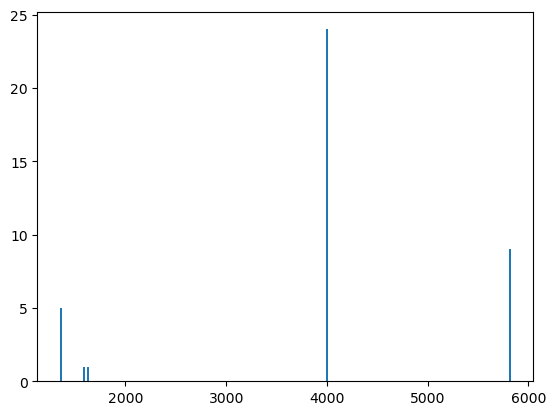

In [215]:
import matplotlib.pyplot as plt

# plot how many genes were dropped per dataset
data = [f[0] for f in filter_2_results if f[0] > 1000]

plt.hist(
    data,
    # density=True,
    bins=200,
)
# plt.yscale("log")

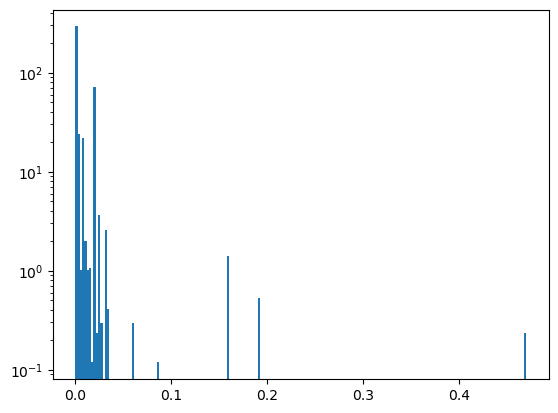

In [211]:
import matplotlib.pyplot as plt

# plot how many genes were dropped per dataset
data = [f[0] / f[1] for f in filter_2_results]

plt.hist(
    data,
    density=True,
    bins=200,
)
plt.yscale("log")

In [1]:
# which studies were dropped the most
[d for d, r in zip(dsaids_pass_filter_1, filter_2_results) if r[0] / r[1] > 0.1]

NameError: name 'dsaids_pass_filter_1' is not defined

In [162]:
 os.path.join("..", "data", "dsa_diff_download", f"{dsaid}_alldiff.txt")

'../data/dsa_diff_download/DSA00004_alldiff.txt'

In [190]:
list(df.columns)

['A', 'B']